<a href="https://colab.research.google.com/github/s528661/nlp100/blob/JDLA_Engeneer_20240503/NLP100Knock_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第6章: 機械学習  
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．  

In [1]:
!pip install mecab-python3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 7.7 MB/s eta 0:00:00


In [2]:
import re,sys,os

import pickle
import time
import copy

import math
import random
import string

from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import scipy as scp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn import feature_extraction, preprocessing

from sklearn import svm
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, f1_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score, confusion_matrix, roc_auc_score

# import dask.array as da

import lightgbm as lgb

# Neural Language Processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import RidgeClassifier
import MeCab

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．  

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．  
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．  
3. 抽出された事例をランダムに並び替える．  
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．  
5. 学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．





In [3]:
# 1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip --no-check-certificate
!unzip ./NewsAggregatorDataset.zip

--2024-05-04 04:54:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas     [         <=>        ]  27.87M  10.1MB/s    in 2.8s    

2024-05-04 04:54:14 (10.1 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203]

Archive:  ./NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [4]:
# 2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
data0 = pd.read_csv('newsCorpora.csv',sep='\t',header=None,
                 names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])
data = data0[data0['PUBLISHER'].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])]

In [5]:
# 3. 抽出された事例をランダムに並び替える．
# 4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
train0, test = train_test_split(data, test_size=0.1, shuffle=True)
train, val = train_test_split(train0, test_size=0.1, shuffle=True)

In [6]:
# 4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
train.to_csv("train.txt", sep="\t", index=False, header=None)
val.to_csv("valid.txt", sep="\t", index=False, header=None)
test.to_csv("test.txt", sep="\t", index=False, header=None)

In [7]:
# 5. 学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．
print("train:{}\nvalid:{}\ntest:{}".format(train.shape, val.shape, test.shape))

train:(10805, 8)
valid:(1201, 8)
test:(1334, 8)


## 51. 特徴量抽出  
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ．   
なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．  

In [8]:
# 前処理（大文字をすべて小文字にする、数字を削除）
def preprocessing(text):
  text = "".join([i for i in text if i not in string.punctuation])
  text = text.lower()
  text = re.sub("[0-9]+", "", text)
  return text

In [9]:
# データを特徴量に変換
## TITLE を小文字にする
data['TITLE'] = data['TITLE'].apply(lambda x: preprocessing(x))

<ipython-input-9-dd55ff3a89e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TITLE'] = data['TITLE'].apply(lambda x: preprocessing(x))


In [10]:
## 1-gram, 2-gramでTfidfを計算
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

X = vectorizer.fit_transform(data['TITLE']).toarray()
X = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

In [11]:
X_train0, X_test = train_test_split(X, test_size=0.1, shuffle=True)
X_train, X_val = train_test_split(X_train0, test_size=0.1, shuffle=True)

In [12]:
X_train.to_csv("train.feature.txt", sep="\t", index=False, header=None)
X_val.to_csv("valid.feature.txt", sep="\t", index=False, header=None)
X_test.to_csv("test.feature.txt", sep="\t", index=False, header=None)

## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [13]:
y_train = data.iloc[X_train.index]['CATEGORY']
y_val = data.iloc[X_val.index]['CATEGORY']
y_test = data.iloc[X_test.index]['CATEGORY']

【補足】ロジスティック回帰  
- 予測値を 0 ~ 1 に変換  
- 確率が高いカテゴリを選択  
  
$\sigma(x) = \frac{1}{1 + \exp^{-x}}$

In [14]:
model = LogisticRegression(random_state=64, max_iter=10000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=10000, random_state=64)

## 53. 予測  
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．  

In [15]:
y_val_pred = model.predict(X_val)
y_val_pred_proba = model.predict_proba(X_val)

In [16]:
y_val_pred

array(['e', 't', 'e', ..., 't', 'b', 'e'], dtype=object)

In [17]:
y_val_pred_proba

array([[0.09575289, 0.7728091 , 0.05114348, 0.08029453],
       [0.13517051, 0.18347642, 0.03441229, 0.64694078],
       [0.19869367, 0.68320042, 0.0441634 , 0.07394251],
       ...,
       [0.04139323, 0.07181833, 0.00809675, 0.87869169],
       [0.62847976, 0.09382522, 0.02816637, 0.24952865],
       [0.19634724, 0.63815145, 0.11910773, 0.04639358]])

## 54. 正解率の計測  
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．  

In [18]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [19]:
print("Train Score: {}\nTest Score: {}".format(accuracy_score(y_train_pred,y_train), accuracy_score(y_test_pred,y_test)))

Train Score: 0.9221656640444239
Test Score: 0.8740629685157422


## 55. 混同行列の作成  
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．  

In [20]:
print("Train Confusion Matrix\n\n{}".format(confusion_matrix(y_train_pred,y_train)))

Train Confusion Matrix

[[4405   63  109  210]
 [ 101 4206  124  141]
 [   9    1  479    6]
 [  54    9   14  874]]


<Axes: >

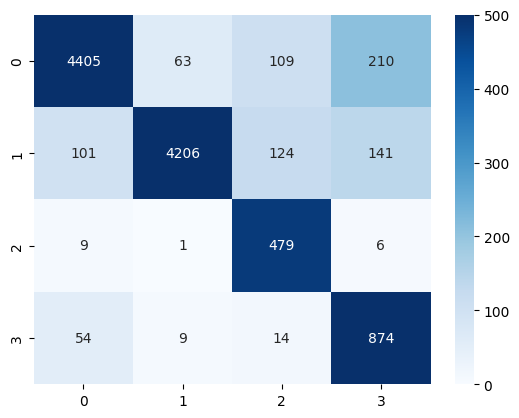

In [21]:
sns.heatmap(confusion_matrix(y_train_pred,y_train), vmin=0, vmax=500, annot=True, fmt='d', cmap='Blues')

In [22]:
print("Test Confusion Matrix\n\n{}".format(confusion_matrix(y_test_pred,y_test)))

Test Confusion Matrix

[[537  19  23  32]
 [ 18 504  23  36]
 [  0   0  49   1]
 [  9   2   5  76]]


<Axes: >

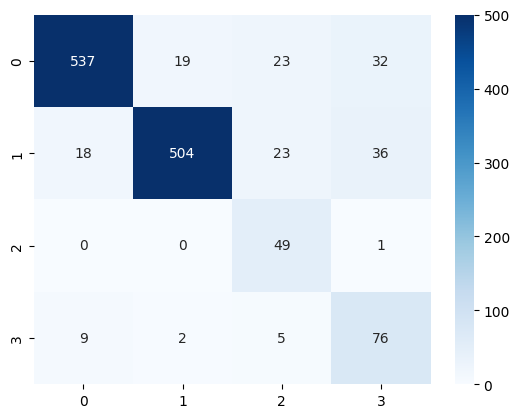

In [23]:
sns.heatmap(confusion_matrix(y_test_pred,y_test), vmin=0, vmax=500, annot=True, fmt='d', cmap='Blues')

## 56. 適合率，再現率，F1スコアの計測  
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．  
カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．  

In [24]:
micro_pricision = precision_score(y_test_pred, y_test, average='micro')
macro_pricision = precision_score(y_test_pred, y_test, average='macro')
print("適合率")
print("マイクロ平均 : {}".format(micro_pricision))
print("マクロ平均 : {}".format(macro_pricision))

適合率
マイクロ平均 : 0.8740629685157422
マクロ平均 : 0.7315663976522377


In [25]:
micro_recall = recall_score(y_test_pred, y_test, average='micro')
macro_recall = recall_score(y_test_pred, y_test, average='macro')
print("再現率")
print("マイクロ平均 : {}".format(micro_recall))
print("マクロ平均 : {}".format(macro_recall))

再現率
マイクロ平均 : 0.8740629685157422
マクロ平均 : 0.8881109766040609


In [26]:
micro_f1 = f1_score(y_test_pred, y_test, average='micro')
macro_f1 = f1_score(y_test_pred, y_test, average='macro')
print("F1スコア")
print("マイクロ平均 : {}".format(micro_f1))
print("マクロ平均 : {}".format(macro_f1))

F1スコア
マイクロ平均 : 0.8740629685157422
マクロ平均 : 0.7800296256396445


## 57. 特徴量の重みの確認  
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ  

In [27]:
features = X_train.columns.values

In [28]:
features

array(['aa', 'aaliyah', 'abbvie', ..., 'zac efron', 'zendaya', 'zone'],
      dtype=object)

In [29]:
for c, coef in zip(model.classes_, model.coef_):
  #print(c,coef)
  #print(sorted(coef))
  #print(np.argsort(coef))
  idx_top5 = np.argsort((-1)*coef)
  idx_worst5 = np.argsort(coef)
  #print(idx)

  print("Top 10 Features in Class '{}'".format(c))
  for i,top in enumerate(features[idx_top5][:10]):
    print("{} : {}".format(i+1,top))

  print("\nWorst 10 Features in Class '{}'".format(c))
  for j,worst in enumerate(features[idx_worst5][:10]):
    print("{} : {}".format(j+1,worst))

  print("\n")

Top 10 Features in Class 'b'
1 : bank
2 : fed
3 : ecb
4 : euro
5 : stocks
6 : oil
7 : ukraine
8 : china
9 : profit
10 : obamacare

Worst 10 Features in Class 'b'
1 : ebola
2 : her
3 : facebook
4 : video
5 : star
6 : the
7 : she
8 : tv
9 : google
10 : comcast


Top 10 Features in Class 'e'
1 : chris
2 : kardashian
3 : her
4 : movie
5 : wedding
6 : kim
7 : film
8 : paul
9 : star
10 : she

Worst 10 Features in Class 'e'
1 : us
2 : update
3 : google
4 : says
5 : study
6 : china
7 : gm
8 : ceo
9 : billion
10 : data


Top 10 Features in Class 'm'
1 : ebola
2 : study
3 : cancer
4 : fda
5 : drug
6 : mers
7 : medical
8 : health
9 : cases
10 : could

Worst 10 Features in Class 'm'
1 : gm
2 : deal
3 : facebook
4 : apple
5 : ceo
6 : amazon
7 : sales
8 : climate
9 : google
10 : profit


Top 10 Features in Class 't'
1 : google
2 : facebook
3 : apple
4 : microsoft
5 : climate
6 : gm
7 : tmobile
8 : heartbleed
9 : comcast
10 : tesla

Worst 10 Features in Class 't'
1 : cancer
2 : drug
3 : fed
4 : his
5

## 58. 正則化パラメータの変更  
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．  
異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．  
実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [30]:
scores = []
for i, param in enumerate(np.logspace(-5, 4, 10, base=10)):
  model0 = LogisticRegression(C=param)
  model0.fit(X_train, y_train)

  y_train_pred0 = model0.predict(X_train)
  y_val_pred0 = model0.predict(X_val)
  y_test_pred0 = model0.predict(X_test)

  scores.append([
      accuracy_score(y_train, y_train_pred0),
      accuracy_score(y_val, y_val_pred0),
      accuracy_score(y_test, y_test_pred0)
  ])

  print("{}:{}".format(i+1,scores[-1]))

1:[0.42285978713558536, 0.4113238967527061, 0.42278860569715143]
2:[0.42285978713558536, 0.4113238967527061, 0.42278860569715143]
3:[0.46210087922258214, 0.443796835970025, 0.4505247376311844]
4:[0.7552059231837113, 0.7285595337218984, 0.7413793103448276]
5:[0.7989819527996298, 0.7726894254787677, 0.7788605697151424]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


6:[0.9221656640444239, 0.8734388009991674, 0.8740629685157422]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


7:[0.9771402128644147, 0.8817651956702748, 0.8943028485757122]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


8:[0.9955576122165664, 0.8701082431307244, 0.8868065967016492]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


9:[0.9980564553447479, 0.8717735220649458, 0.8800599700149925]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


10:[0.998611753817677, 0.8692756036636137, 0.8808095952023988]


In [31]:
npscores = np.array(scores).T

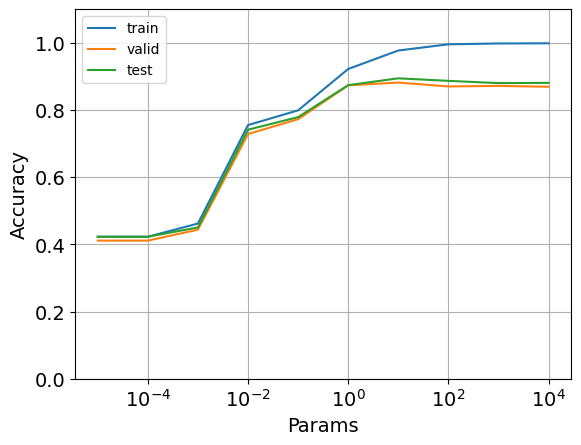

In [32]:
for score, datatype in zip(npscores,['train','valid','test']):
  plt.plot(np.logspace(-5, 4, 10, base=10), score, label=datatype)

plt.ylim(0, 1.1)
plt.xscale('log')
plt.xlabel('Params', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend()

## 59. ハイパーパラメータの探索  
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．  
検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．  
また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [33]:
params = {"C": [0.001, 0.005, 10]}

gs_model = GridSearchCV(LogisticRegression(max_iter=2000),params, cv=6, verbose=1)
gs_model.fit(X_train, y_train)

best_gs_model = gs_model.best_estimator_
print("\ntrain_score: {:.2%}".format(best_gs_model.score(X_train, y_train)))
print("valid_score: {:.2%}".format(best_gs_model.score(X_val, y_val)))
print("test_score: {:.2%}".format(best_gs_model.score(X_test, y_test)))

Fitting 6 folds for each of 3 candidates, totalling 18 fits

train_score: 97.80%
valid_score: 88.01%
test_score: 89.36%
